# DeToxic Tool
Nancy Man

InsightData AI project (MVP version)

This to is to give suggestions to modify offensive language to non-offensive language. The final product is a web app.

Example:
INPUT:

This restraunt is horrible! The service here is bullshit!!!!

OUTPUT:

Suggestion 1: This restraunt is horrible! The service here is bad.

Suggestion 2: The waitress in this restraunt is bad mannered.

Suggestion 3: This restraunt is the worst one I have been.

# Import required packages

In [1]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
#from tensorflow import keras
from keras import backend
from keras import regularizers, Sequential
from keras.layers import Embedding, GlobalAveragePooling1D, Dense
from keras.callbacks import Callback, EarlyStopping
from keras.optimizers import SGD
from keras.models import load_model, model_from_json
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
import numpy as np
from numpy import ndarray
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight
from cophi_toolbox import preprocessing
import pandas as pd
from hatesonar import Sonar
sonar = Sonar()
from collections import defaultdict
from operator import itemgetter
import bisect
import matplotlib.pyplot as plt
import pickle

from model import SiameseBiLSTM
from inputHandler import word_embed_meta_data, create_test_data
from config import siamese_config

/home/cheqin/.conda/envs/deeplearning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Raw Data Review

The data contains 10,000 comments from yelp. The features used in this study include: 
<br>
text: comment text 
<br>
stars: customer ratings (only keep 1 and 5 stars)

In [2]:
data_path = 'yelp.csv'
data = pd.read_csv(data_path)
indx = data[(data.stars != 5)&(data.stars != 1)].index
data = data.drop(indx)
data = data.reset_index(drop=True)
print(len(data))
data.head()

4086


,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
3,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0
4,zp713qNhx8d9KCJJnrw1xA,2010-02-12,riFQ3vxNpP4rWLk_CSri2A,5,Drop what you're doing and drive here. After I...,review,wFweIWhv2fREZV_dYkz_1g,7,7,4


# Data Manipulation

1. Label the toxic identification by Davidson et. al (2017)
<br>
2. Encoder
<br>
3. Find vocabulary size

In [3]:
max_length = 30
all_words = []
toxic_sentences = []
nontoxic_sentences = []
toxic_attitude = []
nontoxic_attitude = []
for i in range(len(data.index)):
    sentences = data['text'][i].replace('\n','').split('.')
    if data['stars'][i] ==1:
        attitude = 0
    elif data['stars'][i] ==5:
        attitude = 1
    for sentence in sentences:
        words = list(preprocessing.tokenize(sentence))
        if len(words) >= 3:
            all_words += words
            class_value = sonar.ping(text=sentence)['top_class']
            if  class_value == 'offensive_language':
                toxic_sentences.append(sentence)
                toxic_attitude.append(attitude)
            else:
                nontoxic_sentences.append(sentence)
                nontoxic_attitude.append(attitude)
encoder = LabelEncoder()
encoder.fit(all_words)
label_encoder_dict = defaultdict(LabelEncoder) 
for key, encoder in label_encoder_dict.items():
    classes = np.array(encoder.classes_).tolist()
    bisect.insort_left(classes, 'UNK')
    encoder.classes_ = classes
vocab_size = len(encoder.classes_)

Define the positive/negative indicator according to the rating: negative if the score is 1 and positive if the score is 5.

In [4]:
X_toxic = []
for sentence in toxic_sentences:
    words = list(preprocessing.tokenize(sentence))
    if len(words) >= 3:
        try:
            words = words[:max_length]
        except:
            pass
        words_idx = np.array(encoder.transform(words))
        arr = np.full(max_length, 0)
        arr[:len(words)] = words_idx
        X_toxic.append(arr)
X_toxic = np.array(X_toxic)
X_toxic_label = np.array(toxic_attitude)


X_nontoxic = []
for sentence in nontoxic_sentences:
    words = list(preprocessing.tokenize(sentence))
    if len(words) >= 3:
        try:
            words = words[:max_length]
        except:
            pass
        words_idx = np.array(encoder.transform(words))
        arr = np.full(max_length, 0)
        arr[:len(words)] = words_idx
        X_nontoxic.append(arr)
X_nontoxic = np.array(X_nontoxic)
X_nontoxic_label = np.array(nontoxic_attitude)

In [5]:
from time import time
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Flatten, Activation, RepeatVector, Permute, Lambda, \
    Bidirectional, TimeDistributed, Dropout, Conv1D, GlobalMaxPool1D
from keras.layers.merge import multiply, concatenate
import keras.backend as K
from util import make_w2v_embeddings, split_and_zero_padding, ManDist
import tensorflow as tf
import numpy as np

def binary_PFA(y_true, y_pred, threshold=K.variable(value=0.5)):  
    y_pred = K.cast(y_pred >= threshold, 'float32')  
    # N = total number of negative labels  
    N = K.sum(1 - y_true)  
    # FP = total number of false alerts, alerts from the negative class labels  
    FP = K.sum(y_pred - y_pred * y_true)  
    return FP/N  

def binary_PTA(y_true, y_pred, threshold=K.variable(value=0.5)):  
    y_pred = K.cast(y_pred >= threshold, 'float32')  
    # P = total number of positive labels  
    P = K.sum(y_true)  
    # TP = total number of correct alerts, alerts from the positive class labels  
    TP = K.sum(y_pred * y_true)  
    return TP/P  

def auc(y_true, y_pred):  
    ptas = tf.stack([binary_PTA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)  
    pfas = tf.stack([binary_PFA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)  
    pfas = tf.concat([tf.ones((1,)) ,pfas],axis=0)  
    binSizes = -(pfas[1:]-pfas[:-1])  
    s = ptas*binSizes  
    return K.sum(s, axis=0) 

In [5]:
# snapshot of the dataset
# print(X_toxic[0:4])
# print(X_nontoxic[0:4])
print(len(X_toxic))
print(len(X_nontoxic))

817
30211


Save the labelled data

In [6]:
toxic_df = pd.DataFrame(toxic_sentences,columns=['Toxic'])
attitude_df = pd.DataFrame(toxic_attitude,columns=['Sentiment'])
toxic_df = pd.concat([toxic_df,attitude_df],axis=1)
toxic_df.to_csv('toxic.csv',index=False)

In [7]:
nontoxic_df = pd.DataFrame(nontoxic_sentences,columns=['Nontoxic'])
attitude_df = pd.DataFrame(nontoxic_attitude,columns=['Sentiment'])
nontoxic_df = pd.concat([nontoxic_df,attitude_df],axis=1)
nontoxic_df.to_csv('nontoxic.csv',index=False)

Save the data and encoder to pickle file

In [8]:

encoder_dict = {'encoder': encoder, 'X_toxic': X_toxic, 'X_toxic_label': X_toxic_label, 'X_nontoxic':X_nontoxic, 'X_nontoxic_label':X_nontoxic_label}

with open('encoder.pickle', 'wb') as handle:
    pickle.dump(encoder_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Build the neural networks and compile the model

Early stopping is applied.

In [6]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='loss', value=0.01, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            print("Early stopping requires %s available!" % self.monitor)
            exit()

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True
earlyStopping=EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

# Build model for toxic dataset.

In [7]:
model_toxic = Sequential()
model_toxic.add(Embedding(vocab_size, 100))
model_toxic.add(GlobalAveragePooling1D())
model_toxic.add(Dense(100, kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01),activation='relu'))
#model_toxic.add(Dense(100, activation='relu'))
model_toxic.add(Dense(1, activation='sigmoid'))
model_toxic.compile(optimizer=SGD(lr=1e-4),loss='binary_crossentropy',metrics=[auc,'accuracy'])

In [8]:
#class_weights = class_weight.compute_class_weight('balanced',np.unique(X_toxic_label),X_toxic)
#https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras/13496

history = model_toxic.fit(X_toxic,
            X_toxic_label,
            validation_split=0.2,
            callbacks=[earlyStopping],
            epochs=40,
            batch_size=32,
            class_weight = 'auto')


Train on 653 samples, validate on 164 samples
Epoch 1/40
653/653 [==============================] - 19s 29ms/step - loss: 1.8744 - auc: 0.3491 - acc: 0.4671 - val_loss: 1.8698 - val_auc: 0.3396 - val_acc: 0.4756
Epoch 2/40
653/653 [==============================] - 2s 2ms/step - loss: 1.8636 - auc: 0.3509 - acc: 0.4793 - val_loss: 1.8586 - val_auc: 0.3587 - val_acc: 0.4878
Epoch 3/40
653/653 [==============================] - 1s 2ms/step - loss: 1.8525 - auc: 0.3399 - acc: 0.4870 - val_loss: 1.8479 - val_auc: 0.3511 - val_acc: 0.5244
Epoch 4/40
653/653 [==============================] - 2s 2ms/step - loss: 1.8410 - auc: 0.3530 - acc: 0.5191 - val_loss: 1.8379 - val_auc: 0.3417 - val_acc: 0.5183
Epoch 5/40
653/653 [==============================] - 2s 3ms/step - loss: 1.8319 - auc: 0.3534 - acc: 0.5452 - val_loss: 1.8283 - val_auc: 0.3400 - val_acc: 0.5610
Epoch 6/40
653/653 [==============================] - 1s 2ms/step - loss: 1.8220 - auc: 0.3275 - acc: 0.5666 - val_loss: 1.8193 - va

In [12]:
# evl = model.evaluate(test_data, test_labels)
# print(evl)

Save the model

In [20]:
model_json = model_toxic.to_json()
with open("toxic_model.json", "w") as json_file:
    json_file.write(model_json)
model_toxic.save_weights("toxic_model.h5")

# Create a graph of accuracy and loss over time

In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

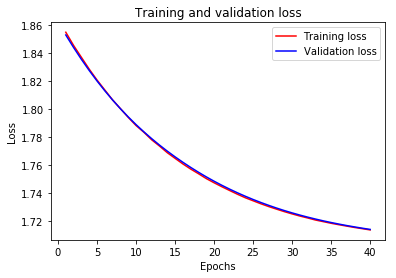

In [22]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

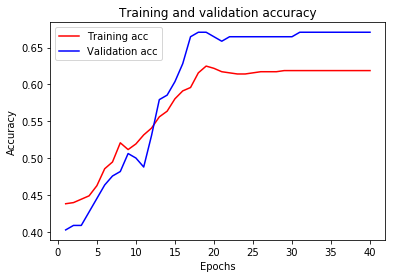

In [23]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Build the model for nontoxic set

In [24]:
model_nontoxic = Sequential()
model_nontoxic.add(Embedding(vocab_size, 100))
model_nontoxic.add(GlobalAveragePooling1D())
model_nontoxic.add(Dense(100, kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01),activation='relu'))
#model_nontoxic.add(keras.layers.Dense(100, reactivation=tf.nn.relu))
model_nontoxic.add(Dense(1, activation='sigmoid'))
model_nontoxic.compile(optimizer=SGD(lr=1e-4),loss='binary_crossentropy',metrics=['accuracy'])

In [25]:
history = model_nontoxic.fit(X_nontoxic,
            X_nontoxic_label,
            validation_split=0.2,
            callbacks=[earlyStopping],
            epochs=40,
            batch_size=128,
            class_weight = 'auto')     

Train on 24168 samples, validate on 6043 samples
Epoch 1/40
24168/24168 [==============================] - 5s 209us/step - loss: 2.1152 - acc: 0.4714 - val_loss: 1.8001 - val_acc: 0.7619
Epoch 2/40
24168/24168 [==============================] - 5s 192us/step - loss: 1.7400 - acc: 0.7738 - val_loss: 1.7143 - val_acc: 0.7665
Epoch 3/40
24168/24168 [==============================] - 5s 194us/step - loss: 1.7085 - acc: 0.7745 - val_loss: 1.7053 - val_acc: 0.7665
Epoch 4/40
24168/24168 [==============================] - 5s 193us/step - loss: 1.7027 - acc: 0.7745 - val_loss: 1.7010 - val_acc: 0.7665
Epoch 5/40
24168/24168 [==============================] - 5s 194us/step - loss: 1.6990 - acc: 0.7745 - val_loss: 1.6976 - val_acc: 0.7665
Epoch 6/40
24168/24168 [==============================] - 5s 195us/step - loss: 1.6958 - acc: 0.7745 - val_loss: 1.6947 - val_acc: 0.7665
Epoch 7/40
24168/24168 [==============================] - 5s 208us/step - loss: 1.6930 - acc: 0.7745 - val_loss: 1.6920 - v

In [26]:
model_json = model_nontoxic.to_json()
with open("nontoxic_model.json", "w") as json_file:
    json_file.write(model_json)
model_nontoxic.save_weights("nontoxic_model.h5")

# Create a graph of accuracy and loss over time

In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

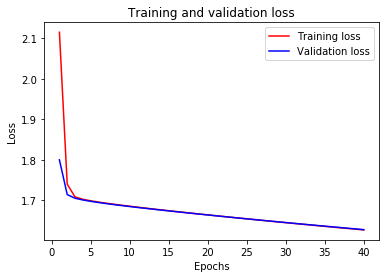

In [28]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

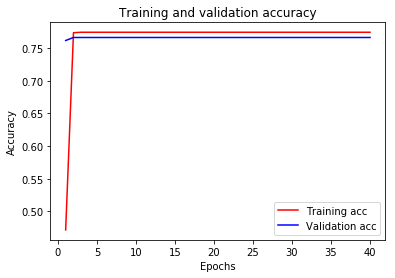

In [29]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras/13496

# Train the similarity lookup

In [72]:
TRAIN_CSV = './quora_train.csv'
embedding_dim = 300
max_seq_length = 10
savepath = './en_SiameseLSTM.h5'


embedding_dict = {}

train_df = pd.read_csv(TRAIN_CSV)
for q in ['question1', 'question2']:
    train_df[q + '_n'] = train_df[q]

train_df, embeddings = make_w2v_embeddings(embedding_dict, train_df, embedding_dim=embedding_dim)

X = train_df[['question1_n', 'question2_n']]
Y = train_df['is_duplicate']
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.1)
X_train = split_and_zero_padding(X_train, max_seq_length)
X_validation = split_and_zero_padding(X_validation, max_seq_length)


Y_train = Y_train.values
Y_validation = Y_validation.values

assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)



def shared_model(_input):

    embedded = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_shape=(max_seq_length,),
                         trainable=False)(_input)

    activations = Bidirectional(LSTM(n_hidden, return_sequences=True), merge_mode='concat')(embedded)
    activations = Bidirectional(LSTM(n_hidden, return_sequences=True), merge_mode='concat')(activations)

    # dropout
    # activations = Dropout(0.5)(activations)

    # Attention
    attention = TimeDistributed(Dense(1, activation='tanh'))(activations)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(n_hidden * 2)(attention)
    attention = Permute([2, 1])(attention)
    sent_representation = multiply([activations, attention])
    sent_representation = Lambda(lambda xin: K.sum(xin, axis=1))(sent_representation)

    # dropout
    # sent_representation = Dropout(0.1)(sent_representation)

    return sent_representation

batch_size = 1024
n_epoch = 9
n_hidden = 50

left_input = Input(shape=(max_seq_length,), dtype='float32')
right_input = Input(shape=(max_seq_length,), dtype='float32')
left_sen_representation = shared_model(left_input)
right_sen_representation = shared_model(right_input)

man_distance = ManDist()([left_sen_representation, right_sen_representation])
sen_representation = concatenate([left_sen_representation, right_sen_representation, man_distance])
similarity = Dense(1, activation='sigmoid')(Dense(2)(Dense(4)(Dense(16)(sen_representation))))
model = Model(inputs=[left_input, right_input], outputs=[similarity])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc])
model.summary()

malstm_trained = model.fit([X_train['left'], X_train['right']], Y_train,
                           batch_size=batch_size, callbacks=[earlyStopping], epochs=n_epoch,
                           validation_data=([X_validation['left'], X_validation['right']], Y_validation))

1000 sentences embedded.
2000 sentences embedded.
3000 sentences embedded.
4000 sentences embedded.
5000 sentences embedded.
6000 sentences embedded.
7000 sentences embedded.
8000 sentences embedded.
9000 sentences embedded.
10000 sentences embedded.
11000 sentences embedded.
12000 sentences embedded.
13000 sentences embedded.
14000 sentences embedded.
15000 sentences embedded.
16000 sentences embedded.
17000 sentences embedded.
18000 sentences embedded.
19000 sentences embedded.
20000 sentences embedded.
21000 sentences embedded.
22000 sentences embedded.
23000 sentences embedded.
24000 sentences embedded.
25000 sentences embedded.
26000 sentences embedded.
27000 sentences embedded.
28000 sentences embedded.
29000 sentences embedded.
30000 sentences embedded.
31000 sentences embedded.
32000 sentences embedded.
33000 sentences embedded.
34000 sentences embedded.
35000 sentences embedded.
36000 sentences embedded.
37000 sentences embedded.
38000 sentences embedded.
39000 sentences embed

309000 sentences embedded.
310000 sentences embedded.
311000 sentences embedded.
312000 sentences embedded.
313000 sentences embedded.
314000 sentences embedded.
315000 sentences embedded.
316000 sentences embedded.
317000 sentences embedded.
318000 sentences embedded.
319000 sentences embedded.
320000 sentences embedded.
321000 sentences embedded.
322000 sentences embedded.
323000 sentences embedded.
324000 sentences embedded.
325000 sentences embedded.
326000 sentences embedded.
327000 sentences embedded.
328000 sentences embedded.
329000 sentences embedded.
330000 sentences embedded.
331000 sentences embedded.
332000 sentences embedded.
333000 sentences embedded.
334000 sentences embedded.
335000 sentences embedded.
336000 sentences embedded.
337000 sentences embedded.
338000 sentences embedded.
339000 sentences embedded.
340000 sentences embedded.
341000 sentences embedded.
342000 sentences embedded.
343000 sentences embedded.
344000 sentences embedded.
345000 sentences embedded.
3

Train on 363861 samples, validate on 40429 samples
Epoch 1/9
363861/363861 [==============================] - 210s 577us/step - loss: 0.5450 - auc: 0.7624 - val_loss: 0.5149 - val_auc: 0.7926
Epoch 2/9
363861/363861 [==============================] - 151s 414us/step - loss: 0.4856 - auc: 0.8234 - val_loss: 0.4972 - val_auc: 0.8110
Epoch 3/9
363861/363861 [==============================] - 147s 404us/step - loss: 0.4465 - auc: 0.8543 - val_loss: 0.4903 - val_auc: 0.8194
Epoch 4/9
363861/363861 [==============================] - 148s 408us/step - loss: 0.4093 - auc: 0.8802 - val_loss: 0.4871 - val_auc: 0.8248
Epoch 5/9
363861/363861 [==============================] - 151s 415us/step - loss: 0.3730 - auc: 0.9022 - val_loss: 0.5022 - val_auc: 0.8252
Epoch 6/9
363861/363861 [==============================] - 149s 409us/step - loss: 0.3370 - auc: 0.9211 - val_loss: 0.5303 - val_auc: 0.8255
Epoch 7/9
363861/363861 [==============================] - 151s 416us/step - loss: 0.3032 - auc: 0.9368

/home/cheqin/.conda/envs/deeplearning/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/cheqin/.conda/envs/deeplearning/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/cheqin/.conda/envs/deeplearning/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/cheqin/.conda/envs/deeplearning/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/cheqin/.conda/envs/deeplearning/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/cheqin/.conda/en

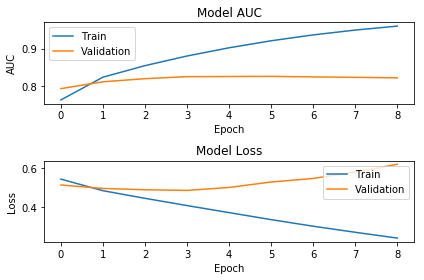

In [74]:
# Plot AUC
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

plt.subplot(211)
plt.plot(malstm_trained.history['auc'])
plt.plot(malstm_trained.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss
plt.subplot(212)
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout(h_pad=1.0)
plt.savefig('./history-graph.png')

model.save(savepath)

Save the pickle file

Wrap up in one function for Flask

In [90]:
json_file_toxic = open('toxic_model.json', 'r')
loaded_model_json_toxic = json_file_toxic.read()
json_file_toxic.close()
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
    loaded_model_toxic = model_from_json(loaded_model_json_toxic)
    loaded_model_toxic.load_weights('toxic_model.h5')

json_file_nontoxic = open('nontoxic_model.json', 'r')

with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
    loaded_model_json_nontoxic = json_file_nontoxic.read()

json_file_nontoxic.close()

with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
    loaded_model_nontoxic = model_from_json(loaded_model_json_nontoxic)
    loaded_model_nontoxic.load_weights('nontoxic_model.h5')
    
with open('encoder.pickle', 'rb') as handle:
    unserialized_data = pickle.load(handle)
encoder=unserialized_data['encoder']

In [102]:
#senti should be 0 or 1, 0 is negative, 1 is positive
def compareSim(input_sentence,modelpath,datapath,senti):
  
    model = load_model(modelpath, custom_objects={"ManDist": ManDist, 'auc':auc})
    #retrive reviews based on input sentiment
    if senti==0:
        datafile=datapath+'/yelp_0.txt'
    elif senti==1:
        datafile=datapath+'/yelp_1.txt'

    with open(datafile) as f:
        datayelp=f.readlines()

    #data cleaning 
    for i in range(len(datayelp)):
        datayelp[i] = datayelp[i].replace('.','').replace('\n','').replace('!','')

    # find the top 3 similar reviews
    result_index=[]
    test_sentence_pairs=[]
    for i in range(len(datayelp)):
        test_sentence=(input_sentence,datayelp[i])
        test_sentence_pairs.append(test_sentence)


    embedding_dict = {}

    test_df = pd.DataFrame(test_sentence_pairs, columns = ['question1','question2'])
    for q in ['question1', 'question2']:
        test_df[q + '_n'] = test_df[q]

    test_df, embeddings = make_w2v_embeddings(embedding_dict, test_df, embedding_dim=300)

    X_test = split_and_zero_padding(test_df, 10)

    assert X_test['left'].shape == X_test['right'].shape

    preds = list(model.predict([X_test['left'], X_test['right']]))

    results = [(x, y, z) for (x, y), z in zip(test_sentence_pairs, preds)]
    results.sort(key=itemgetter(2), reverse=True)


    return results[0:3]

In [100]:
def check_senti(input_sentence):
    words = list(preprocessing.tokenize(input_sentence))
    word_idx = np.array([encoder.transform(words)])
    
    if loaded_model_toxic.predict_proba(word_idx)>0.8:
            senti = 1
    else:
            senti = 0

    return senti

def pred(input_sentence,modelpath,datapath):
    
    class_value = sonar.ping(text=input_sentence)['top_class']
    if class_value == 'offensive_language':
        senti=check_senti(input_sentence)
        results=compareSim(input_sentence,modelpath,datapath,senti)
    else:
        results='NO TOXIC'
    return results

In [103]:
# test 
modelpath='./en_SiameseLSTM.h5'
datapath='.'

input_sen='This place is fucking horrible'
print(check_senti(input_sen))
print(pred(input_sen,modelpath,datapath))

0
[('This place is fucking horrible', "they did n't remake anything ", array([0.9998996], dtype=float32)), ('This place is fucking horrible', 'zero flavor and dry as hell ', array([0.99988925], dtype=float32)), ('This place is fucking horrible', 'as for my mushroom and cheese omelette , the cheese was lacking ', array([0.99985015], dtype=float32))]


# See Validation in validation notebook 